## Code for Final Project: Phys 25000 Computational Physics

#### Creating A Restricted Hartree-Fock SCF Function & Generating Potential Energy Curves 
Author: Abby Pavlicek

Credits: Ruhee D'Cunha, Laura Gagliardi, D.A. Sirianni (Psi4)

Psi4 documentation: https://psicode.org/ , https://psicode.org/psi4manual/master/psiapi.html

### Pseudocode

Given:
- Geometry of a molecule
- Charge and spin multiplicity of a molecule ?
- Basis set
- Max iterations/cycles, memory and convergence criterion

I want a function that returns:
- Ground state RHF energy
- Maybe: Number of iterations, intermediate energies prior to convergence, delta E after each cycle? 
- Maybe: spin? to check for spin contamination??

##### Algorithm
Given initial settings (geom, charge, spin, basis="",max_it = 50, mem=#,energy_tol=#), calculate
- Overlap matrix S
- Core hamiltonian: H = T + V
- Initial transformed Fock mat F'
- Initial transformed orbital coeff mat C' and density mat P

- Nuclear repulsion energy E$_{nuc}$ !!

SCF procedure

For iterations < max iteration, and for delta_energy > tol : 

1. Build fock matrix F

    i. build coloumb matrix J, exchange matrix K
    
    ii. F = H + J - (1/2)K
   
   
2. Find energy: F'C' = C'$\epsilon$ ; E$_{total}$ = E$_{elec}$ + E$_{nuc}$


3. Check for convergence: dE > tol ? 

    i. if converged, return energy, break
    
    ii. if iteration # = max_iteration, break
    
    
4. Else: make a new guess

    i. need new transformed fock mat F', new orbital coeff mat C' and new density mat P

In [85]:
#import python modules
import numpy as np
import psi4 

#psi4 documentation: presets
psi4.set_memory('500 MB')

#input geometry is in zmat format
H2 = psi4.geometry("""
H
H 1 0.74
""") 

N2 = psi4.geometry("""
N
N 1 1.098
""")

O2 = psi4.geometry("""
O
O 1 1.208
""")


In [153]:
def my_rhf_scf(mol,basis,output,damping=0.0,E_conv=1.0e-6,MAX_IT=50):
    
    #### See Psi4 documentation: specifically psi4.core and psi4.core.MintsHelper #### 
    #### See Numpy's eigensolver documentation ####
    psi4.core.clean()
    psi4.core.set_output_file(output,False)
    psi4.set_options({'basis':basis,
                 'scf_type':'pk',
                 'diis':True,
                 'reference': 'rhf',
                 'e_convergence':E_conv})
    
    #compute static 1e- and 2e- quantities
    wfxn = psi4.core.Wavefunction.build(mol, psi4.core.get_global_option('basis'))
    mints = psi4.core.MintsHelper(wfxn.basisset())
    
    #overlap matrix
    S = np.asarray(mints.ao_overlap())
    A = mints.ao_overlap()
    A.power(-0.5,1e-16)
    A = np.asarray(A)
      #number of basis functions and doubly occupied orbitals
    nbf = S.shape[0]
    ndocc = wfxn.nalpha()
    
    #print('Number of occupied orbitals: %3d' % (ndocc))
    #print('Number of basis functions: %3d' % (nbf))
    
    #memory check for ERI tensor
    numpy_memory = 2
    I_size = (nbf**4) * 8.e-9
    #print('\nSize of the ERI tensor will be {:4.2f} GB.'.format(I_size))
    if I_size > numpy_memory:
        psi4.core.clean()
        raise Exception("Estimated memory utilization exceeds allotted memory limit")
    #build ERI tensor
    I = np.asarray(mints.ao_eri())
    
    #build core Hamiltonian
    T = np.asarray(mints.ao_kinetic())
    V = np.asarray(mints.ao_potential())
    H = T + V 
    
    #nuclear repulsion energy
    E_nuc = mol.nuclear_repulsion_energy()
    #print(E_nuc)
       
    # transformed Fock matrix
    F_prime = A.dot(H).dot(A)
    # diagonalize F prime for eigenvalues and eigenvectors using numpy
    e, C_prime = np.linalg.eigh(F_prime)
    #transform back into AO basis
    C = A.dot(C_prime)
    #build density matrix from occupied orbitals
    C_occ = C[:, :ndocc]
    P = 2*np.einsum('pi,qi->pq', C_occ, C_occ, optimize=True)
    
    #now we are ready to start the iterative procedure
    E_SCF = 0.0
    E_old = 0.0
    
    print('==> Starting SCF Iterations <==\n')
    
    for scf_iter in range(1, MAX_IT + 1):
        #build Fock matrix: exchange and overlap integrals
        J = np.einsum('pqrs,rs->pq', I, P, optimize=True)
        K = np.einsum('pqrs,qs->pq', I, P, optimize=True) 
        F = H + J - 0.5*K
        
        #compute RHF energy
        E_SCF = 0.5*np.einsum('pq,pq->', (H+F), P, optimize=True) + E_nuc
        #print('SCF Iteration %3d: Energy = %4.16f dE = % 1.5E' % (scf_iter, E_SCF, E_SCF - E_old))       
        
        #check for convergence
        if (abs(E_SCF - E_old) < E_conv):
            break
        E_old = E_SCF 
        
        #check for max iterations exceeded
        if (scf_iter == MAX_IT):
            psi4.core.clean()
            raise Exception("Maximum number of SCF iterations exceeded.")
        
        #compute new orbital guess (new density matrix), rinse and repeat
        F_prime = A.dot(F).dot(A)
        e, C_prime = np.linalg.eigh(F_prime)
        C = A.dot(C_prime)
        C_occ = C[:, :ndocc]
        
        P_old = P
        P_new = 2 * np.einsum('pi,qi->pq', C_occ, C_occ, optimize=True)
        P = P_old + damping*(P_new - P_old)
        
    print('SCF converged')
    print('Final RHF Energy: %.8f [Eh]' % (E_SCF))
    
    #compare to Psi4's built in RHF function
    psi4.core.set_active_molecule(mol)
    SCF_E_psi = psi4.energy(f'SCF/{basis}')
    print('Psi4 SCF Energy: ' + str(SCF_E_psi))
    #psi4.compare_values(SCF_E_psi, E_SCF, 6, 'SCF Energy')

In [117]:
my_rhf_scf(H2,basis='sto-3g',output='out.out')

Number of occupied orbitals:   1
Number of basis functions:   2

Size of the ERI tensor will be 0.00 GB.
0.7151043387432436
==> Starting SCF Iterations <==

SCF Iteration   1: Energy = -1.1167593073781572 dE = -1.11676E+00
SCF Iteration   2: Energy = -1.1167593073781572 dE =  0.00000E+00
SCF converged
Final RHF Energy: -1.11675931 [Eh]
    SCF Energy............................................................................PASSED


In [142]:
my_rhf_scf(N2,basis='sto-3g',output='out.out',damping=0.3,MAX_IT=500)

==> Starting SCF Iterations <==

SCF Iteration   1: Energy = -103.8489874546828702 dE = -1.03849E+02
SCF Iteration   2: Energy = -105.0455444465343504 dE = -1.19656E+00
SCF Iteration   3: Energy = -105.7472540865567936 dE = -7.01710E-01
SCF Iteration   4: Energy = -106.2301227081023427 dE = -4.82869E-01
SCF Iteration   5: Energy = -106.5614549512924185 dE = -3.31332E-01
SCF Iteration   6: Energy = -106.7901271614178569 dE = -2.28672E-01
SCF Iteration   7: Energy = -106.9473534929644103 dE = -1.57226E-01
SCF Iteration   8: Energy = -107.0542134414945536 dE = -1.06860E-01
SCF Iteration   9: Energy = -107.1254622867889026 dE = -7.12488E-02
SCF Iteration  10: Energy = -107.1715618500423233 dE = -4.60996E-02
SCF Iteration  11: Energy = -107.1999678934581794 dE = -2.84060E-02
SCF Iteration  12: Energy = -107.2160268318987875 dE = -1.60589E-02
SCF Iteration  13: Energy = -107.2236037286694597 dE = -7.57690E-03
SCF Iteration  14: Energy = -107.2255030345922506 dE = -1.89931E-03
SCF Iteration  

In [143]:
my_rhf_scf(O2,basis='sto-3g',output='out.out',damping=0.3,MAX_IT=100)

==> Starting SCF Iterations <==

SCF Iteration   1: Energy = -143.7183514673918125 dE = -1.43718E+02
SCF Iteration   2: Energy = -144.7702882219772960 dE = -1.05194E+00
SCF Iteration   3: Energy = -145.4964267580029116 dE = -7.26139E-01
SCF Iteration   4: Energy = -145.8134271431064803 dE = -3.17000E-01
SCF Iteration   5: Energy = -146.1656544116552539 dE = -3.52227E-01
SCF Iteration   6: Energy = -146.2242816563266388 dE = -5.86272E-02
SCF Iteration   7: Energy = -146.4482132562917798 dE = -2.23932E-01
SCF Iteration   8: Energy = -146.4173010821785113 dE =  3.09122E-02
SCF Iteration   9: Energy = -146.5802622143908991 dE = -1.62961E-01
SCF Iteration  10: Energy = -146.5968826867747623 dE = -1.66205E-02
SCF Iteration  11: Energy = -146.5942540012525512 dE =  2.62869E-03
SCF Iteration  12: Energy = -146.5984779866833208 dE = -4.22399E-03
SCF Iteration  13: Energy = -146.6028692787695888 dE = -4.39129E-03
SCF Iteration  14: Energy = -146.6072182350776814 dE = -4.34896E-03
SCF Iteration  

In [148]:
H2_geoms_list = [
psi4.geometry("""
H
H 1 0.3
"""),
psi4.geometry("""
H
H 1 0.4
"""),
psi4.geometry("""
H
H 1 0.5
"""),
psi4.geometry("""
H
H 1 0.55
"""),
psi4.geometry("""
H
H 1 0.6
"""),
psi4.geometry("""
H
H 1 0.65
"""),
psi4.geometry("""
H
H 1 0.7
""") ,
psi4.geometry("""
H
H 1 0.74
""") ,
psi4.geometry("""
H
H 1 0.8
""") ,
psi4.geometry("""
H
H 1 0.85
""") ,
psi4.geometry("""
H
H 1 0.9
""") ,
psi4.geometry("""
H
H 1 0.95
""") ,
psi4.geometry("""
H
H 1 1.0
""") ,
psi4.geometry("""
H
H 1 1.1
""") ,
psi4.geometry("""
H
H 1 1.2
""") ,
psi4.geometry("""
H
H 1 1.3
"""), 
psi4.geometry("""
H
H 1 1.5
"""),
psi4.geometry("""
H
H 1 1.8
"""),
psi4.geometry("""
H
H 1 2.5
""")
]

In [149]:
for i in range(0,len(H2_geoms_list)):
    my_rhf_scf(H2_geoms_list[i],basis='sto-3g',output='out.out')
    

==> Starting SCF Iterations <==

SCF Iteration   1: Energy = -0.5938277591847825 dE = -5.93828E-01
SCF Iteration   2: Energy = -0.5938277591847825 dE =  0.00000E+00
SCF converged
Final RHF Energy: -0.59382776 [Eh]
Psi4 SCF Energy: -0.5938277591847835
==> Starting SCF Iterations <==

SCF Iteration   1: Energy = -0.9043613945444635 dE = -9.04361E-01
SCF Iteration   2: Energy = -0.9043613945444635 dE =  0.00000E+00
SCF converged
Final RHF Energy: -0.90436139 [Eh]
Psi4 SCF Energy: -0.9043613945444646
==> Starting SCF Iterations <==

SCF Iteration   1: Energy = -1.0429962747511718 dE = -1.04300E+00
SCF Iteration   2: Energy = -1.0429962747511718 dE =  0.00000E+00
SCF converged
Final RHF Energy: -1.04299627 [Eh]
Psi4 SCF Energy: -1.042996274751172
==> Starting SCF Iterations <==

SCF Iteration   1: Energy = -1.0790507363246540 dE = -1.07905E+00
SCF Iteration   2: Energy = -1.0790507363246540 dE =  0.00000E+00
SCF converged
Final RHF Energy: -1.07905074 [Eh]
Psi4 SCF Energy: -1.07905073632465

In [173]:
H2_energy_list=[-0.59382776,-0.90436139,-1.04299627,-1.07905074,-1.10112824,-1.11299655,-1.11734903,-1.11675931,-1.11085040,-1.10251055,-1.09191404,-1.07963693,-1.06610865,-1.03653887,-1.00510671,-0.97311062,-0.91087355,-0.82884815,-0.70294360]
H2_bond_list=[0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.74,0.8,0.85,0.9,0.95,1.0,1.1,1.2,1.3,1.5,1.8,2.5]
H2_psi4_list = [-0.5938277591847835,-0.9043613945444646,-1.042996274751172,-1.0790507363246542,-1.1011282423609587,-1.1129965457166389,-1.1173490349988604,-1.1167593073781577,-1.1108503974239055,-1.1025105538476563,-1.0919140409220973,-1.0796369280940206, -1.0661086491853164, -1.03653887486935,-1.0051067063876664,-0.9731106155813937,-0.9108735543822698,-0.8288481477185704,-0.7029435995786045]

Text(1.45, -0.6, 'Equilibrium Bond Length: 0.74 A')

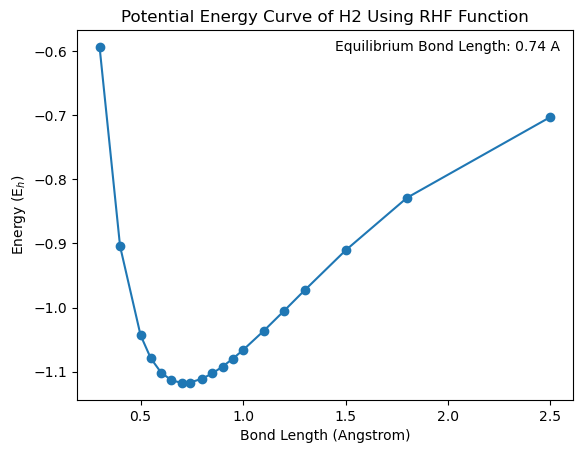

In [199]:
import matplotlib.pyplot as plt

#plt.plot(H2_bond_list,H2_psi4_list,'-o')
plt.plot(H2_bond_list,H2_energy_list,'-o')
plt.title("Potential Energy Curve of H2 Using RHF Function")
plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Energy (E$_{h}$)")
plt.text(1.45,-0.6,"Equilibrium Bond Length: 0.74 A")


[-0.46958125  0.70663097  3.14741282  2.78441091  3.15177888 -0.64762436]


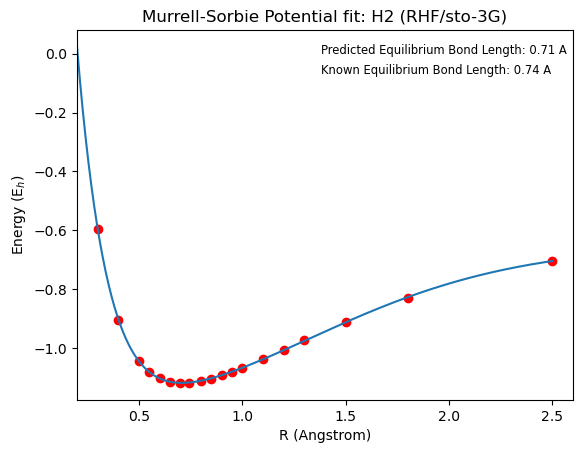

In [200]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

#xdata: array of rvals
xdata2=np.array(H2_bond_list)
ydata2=H2_energy_list
#ydata: list of energy

t=np.linspace(0.2,2.5,500)

tstart = [1.e+7, 0.7, 1, 1 ,1, 0]
def ms(x, q, u, a, b, c, z):
    return q*(1 + a*(x-u) + b*((x-u)**2) + c*((x-u)**3))*np.exp(-a *(x-u)) + z

popt, pcov = curve_fit(ms, xdata2, ydata2, p0 = tstart,  maxfev=40000000)
print(popt)

yfit = ms(t, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5])

#print popt
#
#
#
plt.plot(xdata2, ydata2,"ro")
plt.plot(t, yfit)
plt.title("Murrell-Sorbie Potential fit: H2 (RHF/sto-3G)")
plt.xlabel("R (Angstrom)")
plt.ylabel("Energy (E$_{h}$)")
plt.ticklabel_format(useOffset=False)
plt.xlim(0.2,2.6)
plt.text(1.38,-0.0,"Predicted Equilibrium Bond Length: 0.71 A",fontsize='small')
plt.text(1.38,-0.07,"Known Equilibrium Bond Length: 0.74 A",fontsize='small')
plt.show()

In [156]:
N2_geoms_list = [psi4.geometry("""
N
N 1 0.4
"""),
psi4.geometry("""
N
N 1 0.6
"""), 
psi4.geometry("""
N
N 1 0.8
"""),
psi4.geometry("""
N
N 1 0.9
"""),
psi4.geometry("""
N
N 1 1.0
"""),
psi4.geometry("""
N
N 1 1.1
"""),
psi4.geometry("""
N
N 1 1.2
"""),
psi4.geometry("""
N
N 1 1.3
"""),
psi4.geometry("""
N
N 1 1.5
"""),
psi4.geometry("""
N
N 1 1.8
""")            
    ]

In [177]:
for i in range(0,len(N2_geoms_list)):
    my_rhf_scf(N2_geoms_list[i],basis='sto-3g',output='out.out',damping=0.2,MAX_IT=500)

==> Starting SCF Iterations <==

SCF converged
Final RHF Energy: -185.67628574 [Eh]
Psi4 SCF Energy: -94.45642784400758
==> Starting SCF Iterations <==

SCF converged
Final RHF Energy: -141.34191822 [Eh]
Psi4 SCF Energy: -103.88071561270192
==> Starting SCF Iterations <==

SCF converged
Final RHF Energy: -111.24264051 [Eh]
Psi4 SCF Energy: -106.6808024592972
==> Starting SCF Iterations <==

SCF converged
Final RHF Energy: -105.87487326 [Eh]
Psi4 SCF Energy: -107.18719030250315
==> Starting SCF Iterations <==

SCF converged
Final RHF Energy: -105.44659805 [Eh]
Psi4 SCF Energy: -107.4195324523425
==> Starting SCF Iterations <==

SCF converged
Final RHF Energy: -107.14961463 [Eh]
Psi4 SCF Energy: -107.49650051193096
==> Starting SCF Iterations <==

SCF converged
Final RHF Energy: -107.15397348 [Eh]
Psi4 SCF Energy: -107.48778392783986
==> Starting SCF Iterations <==

SCF converged
Final RHF Energy: -107.13586380 [Eh]
Psi4 SCF Energy: -107.43387068963219
==> Starting SCF Iterations <==

SC

In [170]:
n2_bonds = [0.4,0.6,0.8,0.9,1.0,1.1,1.2,1.3,1.5,1.8]
n2_myrhf = [-185.67628246, -141.34192175 ,-111.24263748, -105.87487055,-105.44658410, -107.14961250,-107.15397114 ,-107.13586033,-107.07872822 , -106.83246490]
n2_psi4 = [-94.45642784400758,-103.88071561270192,-106.6808024592972,-107.18719030250315,-107.4195324523425,-107.49650051193096,-107.48778392783986,-107.43387068963219,-107.27244850058743,-107.01732690661794]

Text(0, 0.5, 'Energy (E$_{h}$)')

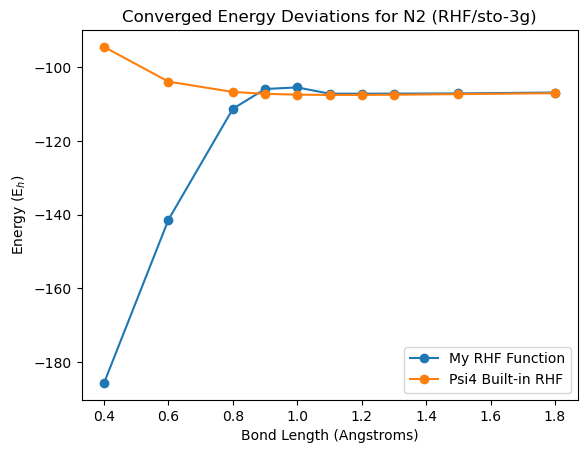

In [203]:
plt.plot(n2_bonds,n2_myrhf,'-o',label="My RHF Function")
plt.plot(n2_bonds,n2_psi4,'-o',label="Psi4 Built-in RHF")
plt.legend(loc='lower right')
plt.title("Converged Energy Deviations for N2 (RHF/sto-3g)")
plt.xlabel("Bond Length (Angstroms)")
plt.ylabel("Energy (E$_{h}$)")